In [1]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import re
from sklearn.utils import shuffle
from collections import OrderedDict
from collections import Counter
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit
from sklearn.inspection import permutation_importance

In [2]:
# Data import

path = './dataset/BGL/BGL_readyToExploitData.csv'
data = pd.read_csv(path)
data_df = pd.DataFrame(data)
data_df.head()

,Session,EventSequence,Label
0,0,"['3aa50e45', '3aa50e45', '3aa50e45', '3aa50e45...",0
1,1,"['d3e73bc3', '60b301fc', 'd3e73bc3', 'd3e73bc3...",1
2,2,"['4983ff07', '4983ff07', '150b1306', '150b1306...",1
3,3,"['3aa50e45', '3aa50e45', 'ba77ab8e', 'ba77ab8e']",0
4,4,"['ba77ab8e', 'd3e73bc3', 'd3e73bc3', 'd3e73bc3...",0


In [3]:
# Shuffle and split the data
def _split_data(x_data, y_data, train_ratio=0.5):
    pos_idx = y_data > 0
    x_pos = x_data[pos_idx]
    y_pos = y_data[pos_idx]
    x_neg = x_data[~pos_idx]
    y_neg = y_data[~pos_idx]
    train_pos = int(train_ratio * x_pos.shape[0])
    train_neg = int(train_ratio * x_neg.shape[0])
    x_train = np.hstack([x_pos[0:train_pos], x_neg[0:train_neg]])
    y_train = np.hstack([y_pos[0:train_pos], y_neg[0:train_neg]])
    x_test = np.hstack([x_pos[train_pos:], x_neg[train_neg:]])
    y_test = np.hstack([y_pos[train_pos:], y_neg[train_neg:]])

    return (x_train, y_train), (x_test, y_test)

In [4]:
# Shuffle the data
shuffled_data_df = data_df.sample(frac=1).reset_index(drop=True)
shuffled_data_df.head(5)

,Session,EventSequence,Label
0,261,"['d3e73bc3', 'd3e73bc3', 'd3e73bc3', 'd3e73bc3...",1
1,647,['3aa50e45'],0
2,336,"['5569cffc', '5569cffc', 'd3e73bc3', 'd3e73bc3...",0
3,339,"['ba77ab8e', '3aa50e45', 'ba77ab8e', 'ba77ab8e...",0
4,832,"['71961023', '7a03d1e9', 'f0c191b1', '7a03d1e9...",0


In [5]:
# Split the dataset by 2:8
# Split train and test data
train_ratio = 0.8
(shuffled_x_train, shuffled_y_train), (shuffled_x_test, shuffled_y_test) = _split_data(shuffled_data_df['EventSequence'].values,
    shuffled_data_df['Label'].values, train_ratio)
# By time sequence
(x_train, y_train), (x_test, y_test) = _split_data(data_df['EventSequence'].values,
    data_df['Label'].values, train_ratio)

In [6]:
num_train = x_train.shape[0]
num_test = x_test.shape[0]
num_total = num_train + num_test
num_train_pos = sum(y_train)
num_test_pos = sum(y_test)
num_pos = num_train_pos + num_test_pos

print('Total: {} instances, {} anomaly, {} normal' \
      .format(num_total, num_pos, num_total - num_pos))
print('Train: {} instances, {} anomaly, {} normal' \
      .format(num_train, num_train_pos, num_train - num_train_pos))
print('Test: {} instances, {} anomaly, {} normal\n' \
      .format(num_test, num_test_pos, num_test - num_test_pos))

Total: 826 instances, 417 anomaly, 409 normal
Train: 660 instances, 333 anomaly, 327 normal
Test: 166 instances, 84 anomaly, 82 normal



# Apply Message Count Vectorizer

In [7]:
# Transfer the unshuffled
# Fit and transform the training data
count_vectorizer = CountVectorizer()
x_train_mcv = count_vectorizer.fit_transform(x_train)
# Transform the testing data
x_test_mcv = count_vectorizer.transform(x_test)

# Transfer the shuffled
# Fit and transform the training data
shuffled_count_vectorizer = CountVectorizer()
shuffled_x_train_mcv = shuffled_count_vectorizer.fit_transform(shuffled_x_train)
# Transform the testing data
shuffled_x_test_mcv = shuffled_count_vectorizer.transform(shuffled_x_test)

print('====== Transformed train data with MCV summary ======')
print('Unshuffled train data shape: {}-by-{}\n'.format(x_train_mcv.shape[0], x_train_mcv.shape[1]))
print('Shuffled train data shape: {}-by-{}\n'.format(shuffled_x_train_mcv.shape[0], shuffled_x_train_mcv.shape[1]))
print('====== Transformed test data with MCV summary ======')
print('Unshuffled train data shape: {}-by-{}\n'.format(x_train_mcv.shape[0], x_train_mcv.shape[1]))
print('Shuffled test data shape: {}-by-{}\n'.format(shuffled_x_test_mcv.shape[0], shuffled_x_test_mcv.shape[1]))

====== Transformed train data with MCV summary ======
Unshuffled train data shape: 660-by-309

Shuffled train data shape: 660-by-344

====== Transformed test data with MCV summary ======
Unshuffled train data shape: 660-by-309

Shuffled test data shape: 166-by-344



In [8]:
# To plot a roc curve
def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

## Create a model performance dataset to apply Scott Nott test

# Construting a logistic regression model
Construct a logistic regrssion model using the trining data, using the *LogisticRegression* method from the **sklearn** library.

In [9]:
# Using the unshuffled data
lr_classifier = LogisticRegression(penalty='l2', C=100, tol=0.01, class_weight=None, max_iter=1000)
lr_classifier.fit(x_train_mcv, y_train)

# Using the shuffled data
shuffled_lr_classifier = LogisticRegression(penalty='l2', C=100, tol=0.01, class_weight=None, max_iter=1000)
shuffled_lr_classifier.fit(shuffled_x_train_mcv, shuffled_y_train)

/home/swendart/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/swendart/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

LogisticRegression(C=100, max_iter=1000, tol=0.01)

Test validation:
====== Evaluation summary ======
Data splitted by time:
Precision: 0.919, recall: 0.405, F1-measure: 0.562



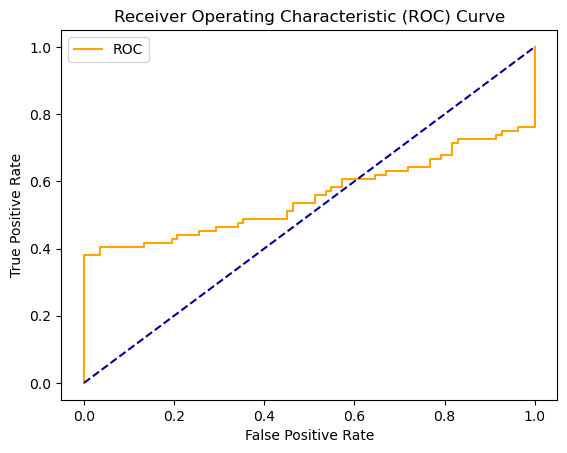

AUC: 0.555

Data splitted by random:
Precision: 0.859, recall: 0.798, F1-measure: 0.827



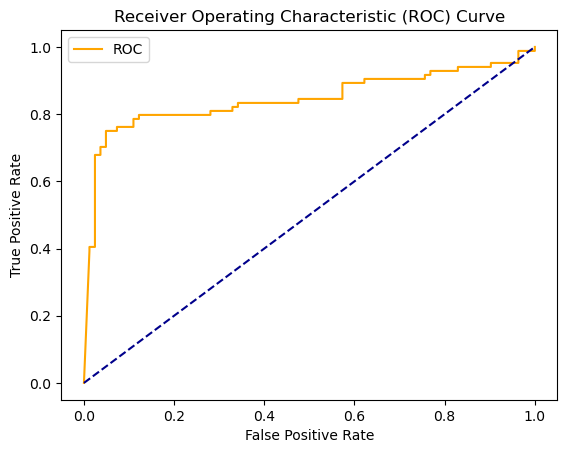

AUC: 0.846



In [10]:
print('Test validation:')
print('====== Evaluation summary ======')
# For the unshuffled data
y_test_pred_lr = lr_classifier.predict(x_test_mcv)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_test_pred_lr, average='binary')
print('Data splitted by time:')
print('Precision: {:.3f}, recall: {:.3f}, F1-measure: {:.3f}\n'.format(precision, recall, f1))

# AUC
y_test_pred_proba_lr = lr_classifier.predict_proba(x_test_mcv)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_proba_lr)
plot_roc_curve(fpr, tpr)
roc_auc = roc_auc_score(y_test, y_test_pred_proba_lr)
print('AUC: %.3f\n' % roc_auc)

# For the shuffled data
shuffled_y_test_pred_lr = shuffled_lr_classifier.predict(shuffled_x_test_mcv)
shuffled_precision, shuffled_recall, shuffled_f1, _ = precision_recall_fscore_support(shuffled_y_test, shuffled_y_test_pred_lr, average='binary')
print('Data splitted by random:')
print('Precision: {:.3f}, recall: {:.3f}, F1-measure: {:.3f}\n'.format(shuffled_precision, shuffled_recall, shuffled_f1))

# AUC
shuffled_y_test_pred_proba_lr = shuffled_lr_classifier.predict_proba(shuffled_x_test_mcv)[:,1]
fpr, tpr, thresholds = roc_curve(shuffled_y_test, shuffled_y_test_pred_proba_lr)
plot_roc_curve(fpr, tpr)
roc_auc = roc_auc_score(shuffled_y_test, shuffled_y_test_pred_proba_lr)
print('AUC: %.3f\n' % roc_auc)

# Constructing a decision tree model
Constructing a decision tree model using the *DecisionTreeClassifier* method from the **sklearn** library.

In [11]:
# Using the unshuffled data
dt_classifier = DecisionTreeClassifier(criterion='gini', max_depth=None,
                          max_features=None, class_weight=None)
dt_classifier.fit(x_train_mcv, y_train)

# Using the shuffled data
shuffled_dt_classifier = DecisionTreeClassifier(criterion='gini', max_depth=None,
                          max_features=None, class_weight=None)
shuffled_dt_classifier.fit(shuffled_x_train_mcv, shuffled_y_train)

DecisionTreeClassifier()

Test validation:
====== Evaluation summary ======
Data splitted by time:
Precision: 1.000, recall: 0.631, F1-measure: 0.774



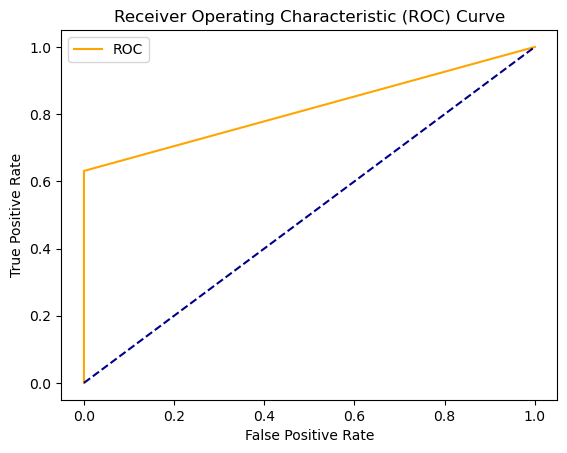

AUC: 0.815

Data splitted by random:
Precision: 0.961, recall: 0.881, F1-measure: 0.919



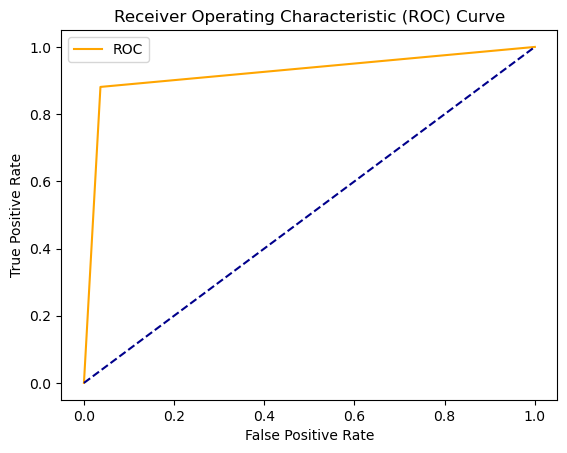

AUC: 0.922



In [12]:
print('Test validation:')
print('====== Evaluation summary ======')
# For the unshuffled data
y_test_pred_dt = dt_classifier.predict(x_test_mcv)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_test_pred_dt, average='binary')
print('Data splitted by time:')
print('Precision: {:.3f}, recall: {:.3f}, F1-measure: {:.3f}\n'.format(precision, recall, f1))

# AUC
y_test_pred_proba_dt = dt_classifier.predict_proba(x_test_mcv)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_proba_dt)
plot_roc_curve(fpr, tpr)
roc_auc = roc_auc_score(y_test, y_test_pred_proba_dt)
print('AUC: %.3f\n' % roc_auc)

# For the shuffled data
shuffled_y_test_pred_dt = shuffled_dt_classifier.predict(shuffled_x_test_mcv)
shuffled_precision, shuffled_recall, shuffled_f1, _ = precision_recall_fscore_support(shuffled_y_test, shuffled_y_test_pred_dt, average='binary')
print('Data splitted by random:')
print('Precision: {:.3f}, recall: {:.3f}, F1-measure: {:.3f}\n'.format(shuffled_precision, shuffled_recall, shuffled_f1))

# AUC
shuffled_y_test_pred_proba_dt = shuffled_dt_classifier.predict_proba(shuffled_x_test_mcv)[:,1]
fpr, tpr, thresholds = roc_curve(shuffled_y_test, shuffled_y_test_pred_proba_dt)
plot_roc_curve(fpr, tpr)
roc_auc = roc_auc_score(shuffled_y_test, shuffled_y_test_pred_proba_dt)
print('AUC: %.3f\n' % roc_auc)

# Constructing a random forest model
Constructing a random forest model using the *RandomForestClassifier* method from the **sklearn** library.

In [13]:
# Using the unshuffled data
rf_classifier = RandomForestClassifier(max_depth=None)
rf_classifier.fit(x_train_mcv, y_train)

# Using the shuffled data
shuffled_rf_classifier = RandomForestClassifier(max_depth=None)
shuffled_rf_classifier.fit(shuffled_x_train_mcv, shuffled_y_train)

RandomForestClassifier()

Test validation:
====== Evaluation summary ======
Data splitted by time:
Precision: 1.000, recall: 0.560, F1-measure: 0.718



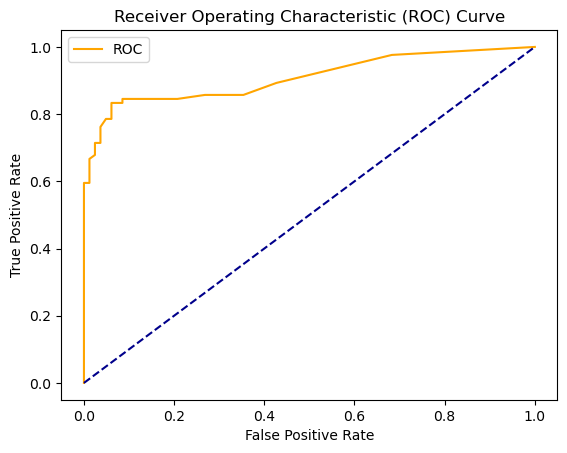

AUC: 0.908

Data splitted by random:
Precision: 0.957, recall: 0.786, F1-measure: 0.863



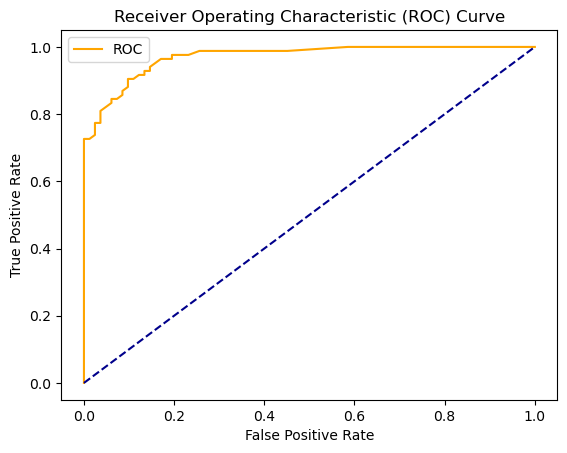

AUC: 0.970



In [14]:
print('Test validation:')
print('====== Evaluation summary ======')
# For the unshuffled data
y_test_pred_rf = rf_classifier.predict(x_test_mcv)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_test_pred_rf, average='binary')
print('Data splitted by time:')
print('Precision: {:.3f}, recall: {:.3f}, F1-measure: {:.3f}\n'.format(precision, recall, f1))

# AUC
y_test_pred_proba_rf = rf_classifier.predict_proba(x_test_mcv)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_proba_rf)
plot_roc_curve(fpr, tpr)
roc_auc = roc_auc_score(y_test, y_test_pred_proba_rf)
print('AUC: %.3f\n' % roc_auc)

# For the shuffled data
shuffled_y_test_pred_rf = shuffled_rf_classifier.predict(shuffled_x_test_mcv)
shuffled_precision, shuffled_recall, shuffled_f1, _ = precision_recall_fscore_support(shuffled_y_test, shuffled_y_test_pred_rf, average='binary')
print('Data splitted by random:')
print('Precision: {:.3f}, recall: {:.3f}, F1-measure: {:.3f}\n'.format(shuffled_precision, shuffled_recall, shuffled_f1))

# AUC
shuffled_y_test_pred_proba_rf = shuffled_rf_classifier.predict_proba(shuffled_x_test_mcv)[:,1]
fpr, tpr, thresholds = roc_curve(shuffled_y_test, shuffled_y_test_pred_proba_rf)
plot_roc_curve(fpr, tpr)
roc_auc = roc_auc_score(shuffled_y_test, shuffled_y_test_pred_proba_rf)
print('AUC: %.3f\n' % roc_auc)

# Constructing a MLP
Constructing a MLP using the *MLPClassifier* method from the **sklearn** library.

In [15]:
# Using the unshuffled data
mlp_classifier = MLPClassifier(max_iter=300).fit(x_train_mcv, y_train)

# Using the shuffled data
shuffled_mlp_classifier = MLPClassifier(max_iter=300).fit(shuffled_x_train_mcv, shuffled_y_train)

Test validation:
====== Evaluation summary ======
Data splitted by time:
Precision: 0.895, recall: 0.405, F1-measure: 0.557



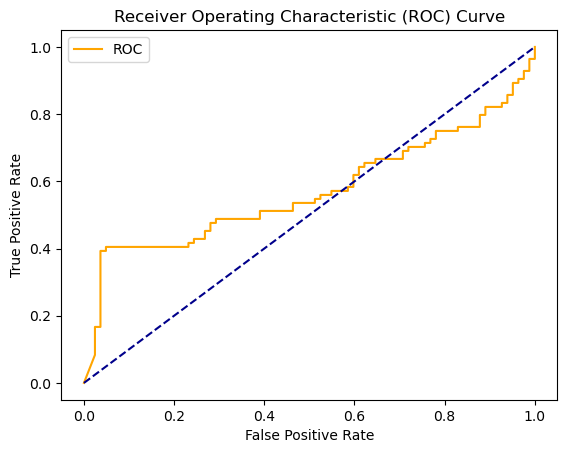

AUC: 0.571

Data splitted by random:
Precision: 0.845, recall: 0.714, F1-measure: 0.774



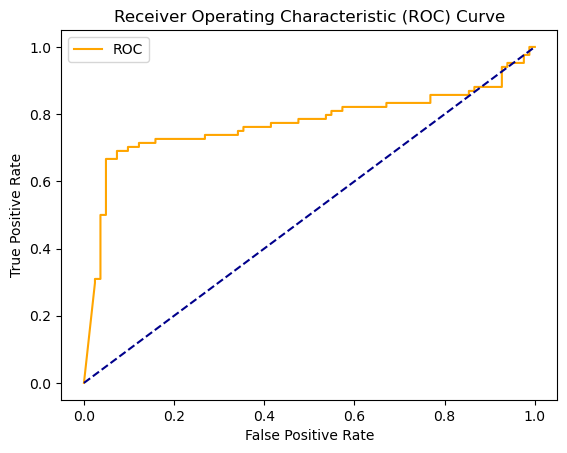

AUC: 0.773



In [16]:
print('Test validation:')
print('====== Evaluation summary ======')
# For the unshuffled data
y_test_pred_mlp = mlp_classifier.predict(x_test_mcv)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_test_pred_mlp, average='binary')
print('Data splitted by time:')
print('Precision: {:.3f}, recall: {:.3f}, F1-measure: {:.3f}\n'.format(precision, recall, f1))

# AUC
y_test_pred_proba_mlp = mlp_classifier.predict_proba(x_test_mcv)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_proba_mlp)
plot_roc_curve(fpr, tpr)
roc_auc = roc_auc_score(y_test, y_test_pred_proba_mlp)
print('AUC: %.3f\n' % roc_auc)

# For the shuffled data
shuffled_y_test_pred_mlp = shuffled_mlp_classifier.predict(shuffled_x_test_mcv)
shuffled_precision, shuffled_recall, shuffled_f1, _ = precision_recall_fscore_support(shuffled_y_test, shuffled_y_test_pred_mlp, average='binary')
print('Data splitted by random:')
print('Precision: {:.3f}, recall: {:.3f}, F1-measure: {:.3f}\n'.format(shuffled_precision, shuffled_recall, shuffled_f1))

# AUC
shuffled_y_test_pred_proba_mlp = shuffled_mlp_classifier.predict_proba(shuffled_x_test_mcv)[:,1]
fpr, tpr, thresholds = roc_curve(shuffled_y_test, shuffled_y_test_pred_proba_mlp)
plot_roc_curve(fpr, tpr)
roc_auc = roc_auc_score(shuffled_y_test, shuffled_y_test_pred_proba_mlp)
print('AUC: %.3f\n' % roc_auc)

# Extension 1: Extend the analyses performed in the replication. Perform the following analyses on one log dataset.

In [17]:
def resample(n):
    for _ in range(n):
        # Shuffle the data
        shuffled_data_df = data_df.sample(frac=1).reset_index(drop=True)
        shuffled_data_df.head(5)

        # Split train and test data
        train_ratio = 0.8
        (shuffled_x_train, shuffled_y_train), (shuffled_x_test, shuffled_y_test) = _split_data(shuffled_data_df['EventSequence'].values,
            shuffled_data_df['Label'].values, train_ratio)

        # Fit and transform the training data
        shuffled_count_vectorizer = CountVectorizer()
        shuffled_x_train_mcv = shuffled_count_vectorizer.fit_transform(shuffled_x_train)
        # Transform the testing data
        shuffled_x_test_mcv = shuffled_count_vectorizer.transform(shuffled_x_test)

        # Fit a linear regression model
        shuffled_lr_classifier = LogisticRegression(penalty='l2', C=100, tol=0.01, class_weight=None, max_iter=1000)
        shuffled_lr_classifier.fit(shuffled_x_train_mcv, shuffled_y_train)
        shuffled_y_test_pred_lr = shuffled_lr_classifier.predict(shuffled_x_test_mcv)
        _, _, shuffled_f1, _ = precision_recall_fscore_support(shuffled_y_test, shuffled_y_test_pred_lr, average='binary')
        lr_f1.append(shuffled_f1)

        # Fit a decision tree model
        shuffled_dt_classifier = DecisionTreeClassifier(criterion='gini', max_depth=None,
                              max_features=None, class_weight=None)
        shuffled_dt_classifier.fit(shuffled_x_train_mcv, shuffled_y_train)
        shuffled_y_test_pred_dt = shuffled_dt_classifier.predict(shuffled_x_test_mcv)
        _, _, shuffled_f1, _ = precision_recall_fscore_support(shuffled_y_test, shuffled_y_test_pred_dt, average='binary')
        dt_f1.append(shuffled_f1)

        # Fit a random forest model
        shuffled_rf_classifier = RandomForestClassifier(max_depth=None)
        shuffled_rf_classifier.fit(shuffled_x_train_mcv, shuffled_y_train)
        shuffled_y_test_pred_rf = shuffled_rf_classifier.predict(shuffled_x_test_mcv)
        _, _, shuffled_f1, _ = precision_recall_fscore_support(shuffled_y_test, shuffled_y_test_pred_rf, average='binary')
        rf_f1.append(shuffled_f1)

        # Fit a MLP
        shuffled_mlp_classifier = MLPClassifier(max_iter=300).fit(shuffled_x_train_mcv, shuffled_y_train)
        shuffled_y_test_pred_mlp = shuffled_mlp_classifier.predict(shuffled_x_test_mcv)
        _, _, shuffled_f1, _ = precision_recall_fscore_support(shuffled_y_test, shuffled_y_test_pred_mlp, average='binary')
        mlp_f1.append(shuffled_f1)

/home/swendart/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/swendart/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

,LR,DT,RF,MLP
0,0.838323,0.939759,0.921212,0.805031
1,0.843373,0.970060,0.927711,0.838323
2,0.843931,0.969697,0.924051,0.875000
3,0.869565,0.970060,0.925000,0.849162
4,0.910180,0.975904,0.888889,0.831325
5,0.870588,0.939759,0.871795,0.855422
6,0.819876,0.957576,0.900000,0.812121
7,0.828402,0.951807,0.952381,0.840237
8,0.905882,0.969697,0.937500,0.855422
9,0.885057,0.951807,0.907975,0.800000


<AxesSubplot:ylabel='AUC'>

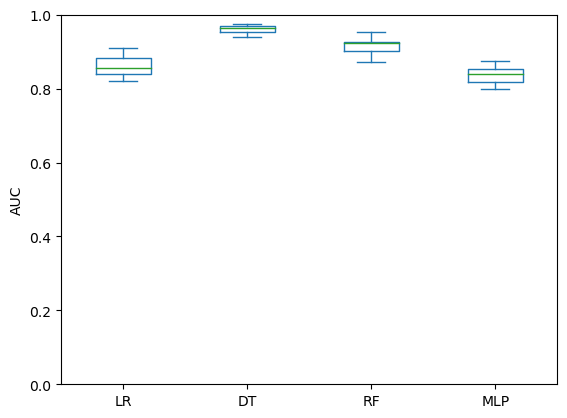

In [18]:
lr_f1, dt_f1, rf_f1, mlp_f1 = [], [], [], []

resample(10)

model_performance_df = pd.DataFrame()
model_performance_df['LR'] = lr_f1
model_performance_df['DT'] = dt_f1
model_performance_df['RF'] = rf_f1
model_performance_df['MLP'] = mlp_f1
model_performance_df.to_csv('result/BGL/model_performance.csv', index = False)
display(model_performance_df)
model_performance_df.plot(kind = 'box', ylim = (0, 1), ylabel = 'AUC')



In [19]:
from PIL import Image

# Open the .png image
image = Image.open("result/BGL/BGL_scottKnottTest.png")  # Replace "example.png" with your image file's path

# Show the image
image.show()

In [20]:
env ARCHFLAGS="-arch i386 -arch x86_64" pip install rpy2

env: ARCHFLAGS="-arch i386 -arch x86_64" pip install rpy2


# Extension 3: Apply correlation analysis (e.g., hierarchical clustering) and redundancy analysis (e.g., variance inflation factor, or VIF analysis) to remove collinearity and multi-collinearity among the features before constructing the models. Compare the performance of the models with and without this step.

# Note: If correlation between 2 variables is greater than 0.8, then we should remove one of them and train the model again.

# Once we complete this, we train the models on the data without correlation between variables and compare its performance with the ones we already trained earlier in this notebook


In [21]:
# Fetch all the feature names
feature_names = shuffled_count_vectorizer.get_feature_names_out()

# Convert x_train_mcv to a dense DataFrame and rename columns
shuffled_x_train_mcv_df = pd.DataFrame(data=shuffled_x_train_mcv.toarray(), columns=feature_names)
shuffled_x_test_mcv_df = pd.DataFrame(data=shuffled_x_test_mcv.toarray(), columns=feature_names)

new_feature_names = shuffled_x_train_mcv_df.columns
print("New Feature Names:", new_feature_names)

New Feature Names: Index(['0045c3a8', '01c4e373', '02430fd4', '0256fb0b', '0315e48d', '0328c31b',
       '045f554d', '04639923', '04f5a2ae', '0509d32d',
       ...
       'f7c382bd', 'f80a5ed5', 'f97e57f1', 'f9df8a24', 'fac52822', 'fb1560b4',
       'fb225cd2', 'fe297487', 'feaae979', 'ff52c40c'],
      dtype='object', length=344)


### Aply Principal Component Analysis

kf.service.services: KApplicationTrader: mimeType "x-scheme-handler/file" not found


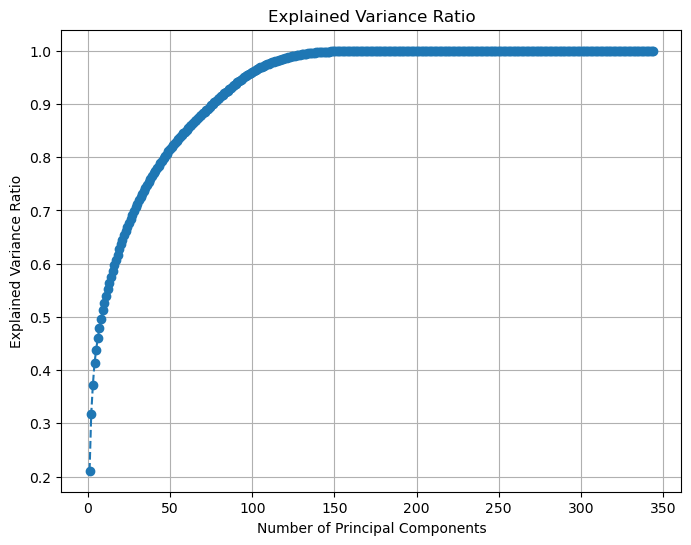

In [22]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df_standardized = scaler.fit_transform(shuffled_x_train_mcv_df)

pca = PCA()
pca.fit(df_standardized)

# Visualize the explained variance ratio
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_.cumsum(), marker='o', linestyle='--')
plt.title('Explained Variance Ratio')
plt.xlabel('Number of Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.grid()
plt.show()

In [23]:
# Determine the number of components to retain (e.g., to capture 95% of variance)
desired_variance = 0.95
n_components = len(pca.explained_variance_ratio_[pca.explained_variance_ratio_.cumsum() < desired_variance]) + 1

# Perform PCA with the selected number of components
pca = PCA(n_components=n_components)
pca_result = pca.fit_transform(shuffled_x_train_mcv_df)

In [24]:
# Get the indices of the top features based on explained variance
top_feature_indices = np.argsort(pca.explained_variance_ratio_)[::-1][:n_components]

# Get retained feature names
retained_feature_names = shuffled_x_train_mcv_df.columns[top_feature_indices]

# Print the results
print("Number of Retained Features:", len(retained_feature_names))
print("Retained Feature Names:", retained_feature_names)

96
Number of Retained Features: 96
Retained Feature Names: Index(['0045c3a8', '01c4e373', '02430fd4', '0256fb0b', '0315e48d', '0328c31b',
       '045f554d', '04639923', '04f5a2ae', '0509d32d', '05588c1a', '058871d3',
       '05cb515f', '05d14ace', '05f7a599', '06072e40', '070de4aa', '0768c287',
       '0791d345', '083912c3', '088bafb1', '09e2160f', '0af83d09', '0b246110',
       '0b5734c3', '0c15e3f5', '0d02c0e2', '0d84da9d', '0dedaecb', '0fae9ddc',
       '117f3d2b', '1195dd00', '11b69b8b', '12c46e92', '12d604f8', '130bb340',
       '13b72099', '1470b976', '147cfcff', '150b1306', '176a1b3b', '18ad7153',
       '19083ffd', '1a3df0d1', '1ae4a1e2', '1b700d02', '1bc8b844', '1bff92a7',
       '1c6b0b26', '1e85eb57', '1f282241', '1f5adb7d', '203e5034', '20aacc26',
       '2199ae24', '220716fc', '22550c73', '22d774b4', '2355b700', '243d8ef7',
       '259ee9a0', '28c5ebea', '2925b8ba', '29a95bd1', '2a8305ff', '2ade14bf',
       '2bfcdc54', '2c4d7668', '2cb01286', '2d239257', '2d40a57d', '2dd1

In [25]:
# Subset the training data
x_train_mcv_subset = shuffled_x_train_mcv_df[retained_feature_names]

# Subset the testing data (if needed)
x_test_mcv_subset = shuffled_x_test_mcv_df[retained_feature_names]

In [26]:
print("Size of x_train_subset:", x_train_mcv_subset.shape)

Size of x_train_subset: (660, 96)


### Apply different models

In [27]:
# Using the shuffled data
lr_classifier = LogisticRegression(penalty='l2', C=100, tol=0.01, class_weight=None, max_iter=1000)
dt_classifier = DecisionTreeClassifier(criterion='gini', max_depth=None,
                          max_features=None, class_weight=None)
rf_classifier = RandomForestClassifier(max_depth=None)
mlp_classifier = MLPClassifier(max_iter=300)

In [28]:
# Create a dictionary of your models
models = {
    'LogisticRegression': lr_classifier,
    'DecisionTree': dt_classifier,
    'RandomForest': rf_classifier,
    'MLP': mlp_classifier
}

results = []

def evaluate_models(x_train, y_train, x_test, y_test, analysis):  
    print('Test validation:')
    print('====== Evaluation summary ======')

    for model_name, model in models.items():
        # Fit the model on the training data (if not already done)
        model.fit(x_train, y_train)

        # Make predictions on the test data
        y_test_pred = model.predict(x_test)

        # Calculate precision, recall, and F1-score
        precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_test_pred, average='binary')

        print(f'Model: {model_name}')
        print('Data splitted by random:')
        print(f'Precision: {precision:.3f}, recall: {recall:.3f}, F1-measure: {f1:.3f}')

        # Calculate AUC
        y_test_pred_proba = model.predict_proba(x_test)[:, 1]
        
        fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_proba)
        roc_auc = roc_auc_score(y_test, y_test_pred_proba)

        print(f'AUC: {roc_auc:.3f}\n')

        results.append({
            'Model': model_name,
            'Correlation and Redudancy Analysis': analysis,
            'Precision': precision,
            'Recall': recall,
            'F1-score': f1,
            'AUC': roc_auc
    })

evaluate_models(x_train_mcv_subset, shuffled_y_train, x_test_mcv_subset, shuffled_y_test, True)

Test validation:
====== Evaluation summary ======


kf.i18n.kuit: "Unknown subcue ':whatsthis,' in UI marker in context {@info:whatsthis, %1 the action's text}."
org.kde.kdegraphics.gwenview.lib: Unresolved mime type  "image/x-aptus-mos"
org.kde.kdegraphics.gwenview.lib: Unresolved mime type  "image/x-arq"
org.kde.kdegraphics.gwenview.lib: Unresolved mime type  "image/x-bay"
org.kde.kdegraphics.gwenview.lib: Unresolved mime type  "image/x-bmq"
org.kde.kdegraphics.gwenview.lib: Unresolved mime type  "image/x-cap"
org.kde.kdegraphics.gwenview.lib: Unresolved mime type  "image/x-cine"
org.kde.kdegraphics.gwenview.lib: Unresolved mime type  "image/x-cs1"
org.kde.kdegraphics.gwenview.lib: Unresolved mime type  "image/x-dc2"
org.kde.kdegraphics.gwenview.lib: Unresolved mime type  "image/x-drf"
org.kde.kdegraphics.gwenview.lib: Unresolved mime type  "image/x-dxo"
org.kde.kdegraphics.gwenview.lib: Unresolved mime type  "image/x-epson-eip"
org.kde.kdegraphics.gwenview.lib: Unresolved mime type  "image/x-epson-erf"
org.kde.kdegraphics.gwenview.li

Model: LogisticRegression
Data splitted by random:
Precision: 0.912, recall: 0.738, F1-measure: 0.816
AUC: 0.845

Model: DecisionTree
Data splitted by random:
Precision: 0.893, recall: 0.798, F1-measure: 0.843
AUC: 0.834

Model: RandomForest
Data splitted by random:
Precision: 0.926, recall: 0.750, F1-measure: 0.829
AUC: 0.919

Model: MLP
Data splitted by random:
Precision: 0.952, recall: 0.702, F1-measure: 0.808
AUC: 0.817



In [29]:
# Using the unshuffled data
lr_classifier = LogisticRegression(penalty='l2', C=100, tol=0.01, class_weight=None, max_iter=1000)
dt_classifier = DecisionTreeClassifier(criterion='gini', max_depth=None,
                          max_features=None, class_weight=None)
rf_classifier = RandomForestClassifier(max_depth=None)
mlp_classifier = MLPClassifier(max_iter=300)

evaluate_models(x_train_mcv, y_train, x_test_mcv, y_test, False)

Test validation:
====== Evaluation summary ======


/home/swendart/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model: LogisticRegression
Data splitted by random:
Precision: 0.919, recall: 0.405, F1-measure: 0.562
AUC: 0.555

Model: DecisionTree
Data splitted by random:
Precision: 1.000, recall: 0.595, F1-measure: 0.746
AUC: 0.798

Model: RandomForest
Data splitted by random:
Precision: 1.000, recall: 0.571, F1-measure: 0.727
AUC: 0.899

Model: MLP
Data splitted by random:
Precision: 0.967, recall: 0.345, F1-measure: 0.509
AUC: 0.566



In [30]:
csv_file_path = 'result/BGL/perforamnce_evaluation_results_with_PCA.csv'

results_df = pd.DataFrame(results)

# Save the DataFrame as a CSV file
results_df.to_csv(csv_file_path, index=False)

print(results_df)

                Model  Correlation and Redudancy Analysis  Precision  \
0  LogisticRegression                                True   0.911765   
1        DecisionTree                                True   0.893333   
2        RandomForest                                True   0.926471   
3                 MLP                                True   0.951613   
4  LogisticRegression                               False   0.918919   
5        DecisionTree                               False   1.000000   
6        RandomForest                               False   1.000000   
7                 MLP                               False   0.966667   

     Recall  F1-score       AUC  
0  0.738095  0.815789  0.845311  
1  0.797619  0.842767  0.834495  
2  0.750000  0.828947  0.918772  
3  0.702381  0.808219  0.817291  
4  0.404762  0.561983  0.554878  
5  0.595238  0.746269  0.797619  
6  0.571429  0.727273  0.898519  
7  0.345238  0.508772  0.565767  


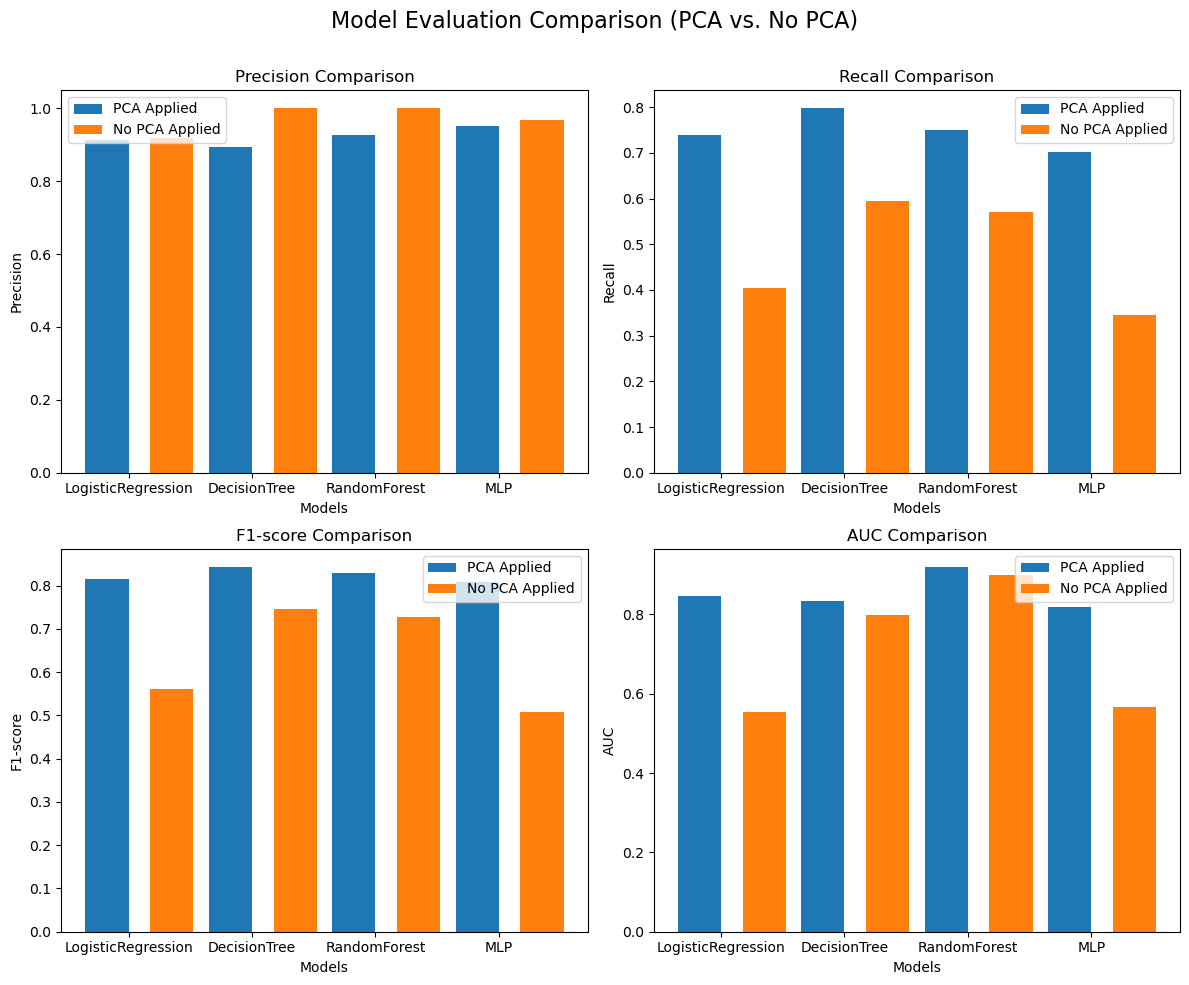

In [31]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have the results in results_df

# Filter the DataFrame based on PCA applied or not
results_pca = results_df[results_df['Correlation and Redudancy Analysis'] == True]
results_no_pca = results_df[results_df['Correlation and Redudancy Analysis'] == False]

# Model names
model_names = results_pca['Model']

# Performance metrics
metrics = ['Precision', 'Recall', 'F1-score', 'AUC']

# Number of models
num_models = len(model_names)

# Set the width of the bars
bar_width = 0.35

# Create an array of positions for each group of bars
x = np.arange(num_models)

# Create subplots for each metric
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle('Model Evaluation Comparison (PCA vs. No PCA)', fontsize=16)

for i, metric in enumerate(metrics):
    row = i // 2
    col = i % 2
    ax = axes[row, col]

    # Get metric values for PCA and No PCA
    metric_values_pca = results_pca[metric]
    metric_values_no_pca = results_no_pca[metric]

    # Plot the bar chart
    ax.bar(x - bar_width/2, metric_values_pca, bar_width, label='PCA Applied', align='center')
    ax.bar(x + bar_width/2, metric_values_no_pca, bar_width, label='No PCA Applied', align='edge')

    ax.set_title(f'{metric} Comparison')
    ax.set_xlabel('Models')
    ax.set_ylabel(metric)
    ax.set_xticks(x)
    ax.set_xticklabels(model_names)
    ax.legend()

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()
